# AbLangRBD1 Inference Examples

**SARS-CoV-2 RBD Antibody Embedding Model**

This notebook demonstrates how to use **AbLangRBD1** to generate epitope-aware embeddings for SARS-CoV-2 RBD-binding antibodies.

## Key Features
- **Epitope-aware embeddings**: Antibodies targeting similar RBD epitopes cluster together
- **1536-dimensional embeddings**: Rich representations for downstream analysis
- **Contrastive learning**: Trained to distinguish between different RBD epitope classes

## Use Cases
1. **RBD Epitope Classification**: Compare antibodies against reference databases
2. **Therapeutic Discovery**: Find antibodies with similar epitope specificity
3. **Vaccine Analysis**: Analyze repertoire shifts after RBD vaccination
4. **Cross-reactivity Prediction**: Identify broadly neutralizing antibodies

## Setup and Installation

In [1]:
# Install required packages (uncomment if needed)
# !pip install torch pandas transformers safetensors huggingface_hub

In [10]:
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer
from ablangpaired_model import AbLangPaired, AbLangPairedConfig
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

print("AbLangRBD1 Inference Examples")
print("All packages imported successfully!")

AbLangRBD1 Inference Examples
All packages imported successfully!


## Model Loading

In [11]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load model from HuggingFace Hub
print("\nLoading AbLangRBD1 model...")
try:
    from huggingface_hub import hf_hub_download
    
    # Download model weights
    model_path = hf_hub_download(
        repo_id="clint-holt/AbLangRBD1",
        filename="model.safetensors"
    )
    
    config = AbLangPairedConfig(checkpoint_filename=model_path)
    model = AbLangPaired(config, device).to(device)
    model.eval()
    print("✅ Model loaded successfully!")
    
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("Make sure you have internet connection and huggingface_hub installed")

# Load tokenizers
print("\nLoading tokenizers...")
try:
    heavy_tokenizer = AutoTokenizer.from_pretrained("clint-holt/AbLangRBD1", subfolder="heavy_tokenizer")
    light_tokenizer = AutoTokenizer.from_pretrained("clint-holt/AbLangRBD1", subfolder="light_tokenizer")
    print("✅ Tokenizers loaded successfully!")
except Exception as e:
    print(f"❌ Error loading tokenizers: {e}")

Using device: cuda

Loading AbLangRBD1 model...
✅ Model loaded successfully!

Loading tokenizers...
✅ Tokenizers loaded successfully!


## Example 1: Single RBD Antibody Embedding

In [12]:
# Example SARS-CoV-2 RBD antibody from training data
heavy_chain = "EVQLVESGGGFVQPGRSLRLSCAASGFIMDDYAMHWVRQAPGKGLEWVSGISWNSGTRGYADSVKGRFTVSRDNAKNSFYLQMNSLRAADTAVYYCAKDHGPWIAANGHYFDYWGQGTLVTVSS"
light_chain = "QSVLTQPPSASGTPGQRVTISCSGSKSNIGSNPVNWYQQLPGTAPKLLIYSNNERPSGVPARFSGSKSGTSASLAISGLQSEDEADYYCVTWDDSLNGWVFGGGTKLTVL"

print("Processing RBD antibody:")
print(f"Heavy chain: {heavy_chain}")
print(f"Light chain: {light_chain}")

# Tokenize (add spaces between amino acids)
h_tokens = heavy_tokenizer(" ".join(heavy_chain), return_tensors="pt")
l_tokens = light_tokenizer(" ".join(light_chain), return_tensors="pt")

# Generate embedding
with torch.no_grad():
    embedding = model(
        h_input_ids=h_tokens['input_ids'].to(device),
        h_attention_mask=h_tokens['attention_mask'].to(device),
        l_input_ids=l_tokens['input_ids'].to(device),
        l_attention_mask=l_tokens['attention_mask'].to(device)
    )

print(f"\n✅ Generated embedding:")
print(f"Shape: {embedding.shape}")
print(f"First 10 values: {embedding[0][:10].tolist()}")
print(f"L2 norm: {torch.norm(embedding[0]).item():.4f} (should be ~1.0 for normalized embeddings)")

Processing RBD antibody:
Heavy chain: EVQLVESGGGFVQPGRSLRLSCAASGFIMDDYAMHWVRQAPGKGLEWVSGISWNSGTRGYADSVKGRFTVSRDNAKNSFYLQMNSLRAADTAVYYCAKDHGPWIAANGHYFDYWGQGTLVTVSS
Light chain: QSVLTQPPSASGTPGQRVTISCSGSKSNIGSNPVNWYQQLPGTAPKLLIYSNNERPSGVPARFSGSKSGTSASLAISGLQSEDEADYYCVTWDDSLNGWVFGGGTKLTVL

✅ Generated embedding:
Shape: torch.Size([1, 1536])
First 10 values: [-0.030358636751770973, 0.004947466775774956, -0.008579566143453121, 0.005523608531802893, -0.010611900128424168, 0.024195805191993713, 0.02292603813111782, 0.02204192988574505, 0.01653214544057846, -0.016096021980047226]
L2 norm: 1.0000 (should be ~1.0 for normalized embeddings)


## Example 2: Batch Processing Multiple RBD Antibodies

In [13]:
# Example dataset with multiple SARS-CoV-2 RBD antibodies representing different epitope classes
rbd_antibodies = {
    'Antibody_ID': ['RBD_Ab1', 'RBD_Ab2', 'RBD_Ab3', 'RBD_Ab4', 'RBD_Ab5'],
    'HC_AA': [
        "EVQLVESGGGFVQPGRSLRLSCAASGFIMDDYAMHWVRQAPGKGLEWVSGISWNSGTRGYADSVKGRFTVSRDNAKNSFYLQMNSLRAADTAVYYCAKDHGPWIAANGHYFDYWGQGTLVTVSS",  # Class 1 epitope
        "QVQLQESGPGLVKPSETLSLTCTVSGGSISSSYYWTWIRQPPGKGLEWIGSIYHSGSTYYNPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCARGHWLVGGFDYWGQGTLVTVSS",  # Class 2 epitope
        "EVQLVESGGGLVQPGGSLRLSCAASGFTFRDYAMHWVRQAPGKGLEWVAVISYDGSNKYYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCARDHGGDHDYWGQGTLVTVSS",  # Class 3 epitope
        "QVQLVESGGGVVQPGRSLRLSCAASGFTFSSYAMSWVRQAPGKGLEWVSAISGSGGSTYYADSVKGRFTISRDTSKNQAYLQMNSLRAEDTAVYYCARFDGSGPFDYWGQGTLVTVSS",  # Class 4 epitope
        "EVQLVESGLLFVQPGRSLRLSCAASGFIMDDYAMHWVRQAPGKGLEWVSGISWNSGTRGYADSVKGRFTVSRDNAKNSFYLQMNSLRAADTAVYYCAKDHGPWIAANGHYFDYWGQGTLVTVSS"   # Class 1 epitope (similar to Ab1)
    ],
    'LC_AA': [
        "QSVLTQPPSASGTPGQRVTISCSGSKSNIGSNPVNWYQQLPGTAPKLLIYSNNERPSGVPARFSGSKSGTSASLAISGLQSEDEADYYCVTWDDSLNGWVFGGGTKLTVL",
        "DIQMTQSPSSLSASVGDRVTITCKASQDIYSSLSWYQQKPGKAPKLLIYSTSRLNSGVPSRFSGSGSGTDFTFTISSLQPEDIATYYCQHYYSAPMTFGQGTKLEIK",
        "QSVLTQPPSVSAAPGQKVTISCSGSSSNIGSNYVSWYQQLPGTAPKLVIYSNNQRPSGVPDRFSGSKSGTSASLAISGLQSEDEADYYCATWDDSLSGYVFGTGTKVTVL",
        "DIQMTQSPSSLSASVGDRVTITCRASQSVSSSLAWYQQKPGKAPKLLIYGASSRATGIPDRFSGSGSGTDFTLTISRLEPEDFAVYYCQQYGSSPLTFGQGTKVEIK",
        "QSVLTQPPASSGTPGQRVTISCSGSKSNIGSNPVNWYQQLPGTAPKLLIYSNNERPSGVPARFSGSKSGTSASLAISGLQSEDEADYYCVTWDDSLNGWVFGGGTKLTVL"
    ],
    'Epitope_Class': ['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_1']  # Expected epitope classes
}

df = pd.DataFrame(rbd_antibodies)
print("RBD Antibody Dataset:")
print(df[['Antibody_ID', 'Epitope_Class']].to_string(index=False))

# Preprocess sequences
df["PREPARED_HC_SEQ"] = df["HC_AA"].apply(lambda x: " ".join(list(x)))
df["PREPARED_LC_SEQ"] = df["LC_AA"].apply(lambda x: " ".join(list(x)))

# Tokenize batch
print("\nTokenizing batch...")
h_tokens_batch = heavy_tokenizer(df["PREPARED_HC_SEQ"].tolist(), padding='longest', return_tensors="pt")
l_tokens_batch = light_tokenizer(df["PREPARED_LC_SEQ"].tolist(), padding='longest', return_tensors="pt")

# Generate embeddings
print("Generating embeddings...")
with torch.no_grad():
    embeddings_batch = model(
        h_input_ids=h_tokens_batch['input_ids'].to(device),
        h_attention_mask=h_tokens_batch['attention_mask'].to(device),
        l_input_ids=l_tokens_batch['input_ids'].to(device),
        l_attention_mask=l_tokens_batch['attention_mask'].to(device)
    )

print(f"\n✅ Generated batch embeddings: {embeddings_batch.shape}")
print(f"Number of antibodies: {embeddings_batch.shape[0]}")
print(f"Embedding dimension: {embeddings_batch.shape[1]}")

RBD Antibody Dataset:
Antibody_ID Epitope_Class
    RBD_Ab1       Class_1
    RBD_Ab2       Class_2
    RBD_Ab3       Class_3
    RBD_Ab4       Class_4
    RBD_Ab5       Class_1

Tokenizing batch...
Generating embeddings...

✅ Generated batch embeddings: torch.Size([5, 1536])
Number of antibodies: 5
Embedding dimension: 1536


## Example 3: Epitope Similarity Analysis

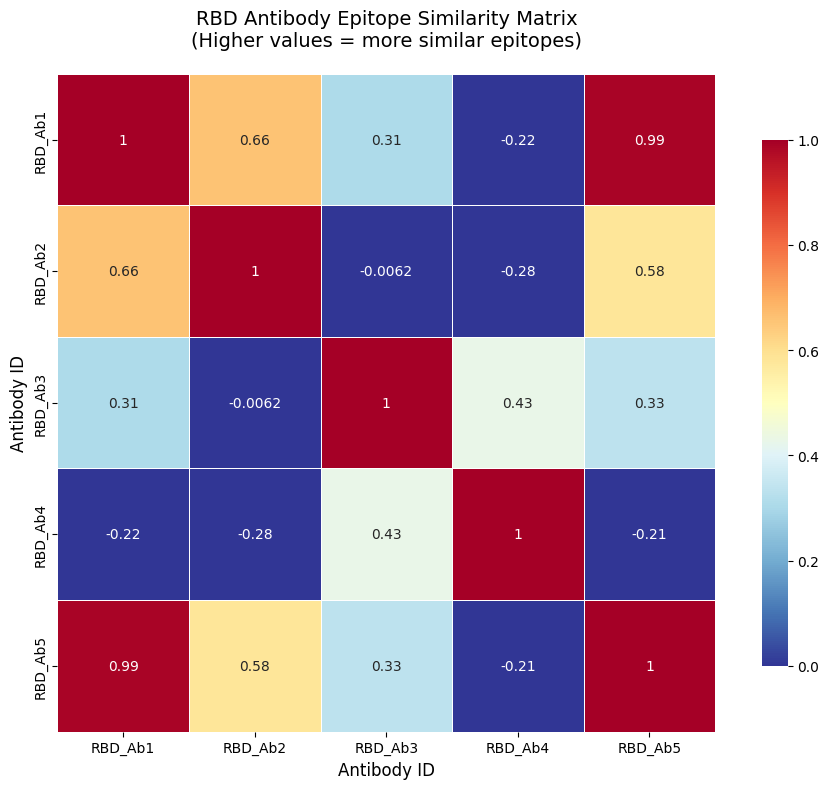


Epitope Similarity Analysis:
RBD_Ab1 vs RBD_Ab2: 0.658 (Class_1 vs Class_2) - ❌ Different epitope
RBD_Ab1 vs RBD_Ab3: 0.308 (Class_1 vs Class_3) - ❌ Different epitope
RBD_Ab1 vs RBD_Ab4: -0.224 (Class_1 vs Class_4) - ❌ Different epitope
RBD_Ab1 vs RBD_Ab5: 0.991 (Class_1 vs Class_1) - ✅ Same epitope
RBD_Ab2 vs RBD_Ab3: -0.006 (Class_2 vs Class_3) - ❌ Different epitope
RBD_Ab2 vs RBD_Ab4: -0.281 (Class_2 vs Class_4) - ❌ Different epitope
RBD_Ab2 vs RBD_Ab5: 0.579 (Class_2 vs Class_1) - ❌ Different epitope
RBD_Ab3 vs RBD_Ab4: 0.428 (Class_3 vs Class_4) - ❌ Different epitope
RBD_Ab3 vs RBD_Ab5: 0.333 (Class_3 vs Class_1) - ❌ Different epitope
RBD_Ab4 vs RBD_Ab5: -0.212 (Class_4 vs Class_1) - ❌ Different epitope


In [14]:
# Calculate pairwise cosine similarities
similarities = torch.cosine_similarity(embeddings_batch.unsqueeze(1), embeddings_batch.unsqueeze(0), dim=2)
similarity_matrix = similarities.cpu().numpy()

# Create similarity heatmap
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(similarity_matrix, dtype=bool), k=1)
sns.heatmap(
    similarity_matrix, 
    annot=True, 
    cmap='RdYlBu_r', 
    vmin=0, 
    vmax=1,
    xticklabels=df['Antibody_ID'],
    yticklabels=df['Antibody_ID'],
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": .8}
)
plt.title('RBD Antibody Epitope Similarity Matrix\n(Higher values = more similar epitopes)', fontsize=14, pad=20)
plt.xlabel('Antibody ID', fontsize=12)
plt.ylabel('Antibody ID', fontsize=12)
plt.tight_layout()
plt.show()

# Print detailed similarity analysis
print("\nEpitope Similarity Analysis:")
print("=" * 50)
for i in range(len(df)):
    for j in range(i+1, len(df)):
        ab1, ab2 = df.iloc[i]['Antibody_ID'], df.iloc[j]['Antibody_ID']
        class1, class2 = df.iloc[i]['Epitope_Class'], df.iloc[j]['Epitope_Class']
        sim = similarity_matrix[i, j]
        expected = "✅ Same epitope" if class1 == class2 else "❌ Different epitope"
        print(f"{ab1} vs {ab2}: {sim:.3f} ({class1} vs {class2}) - {expected}")

## Example 4: Dimensionality Reduction and Visualization

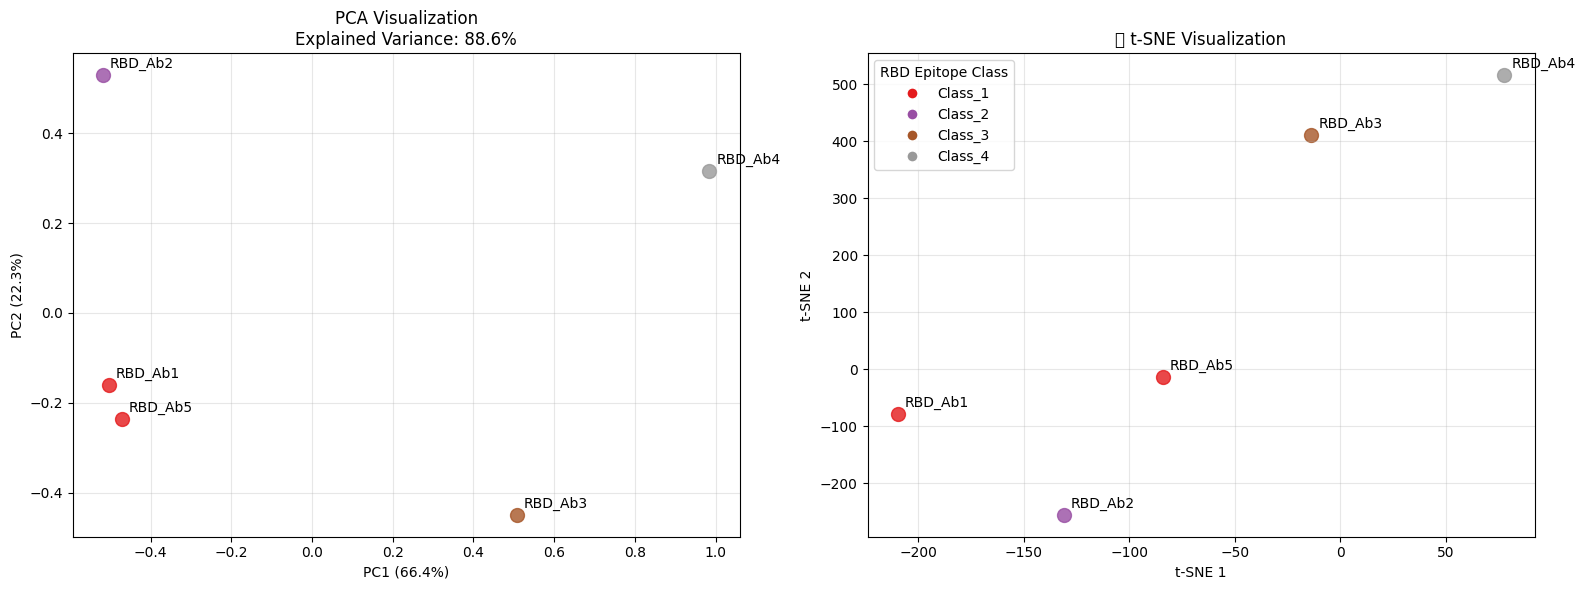


Visualization Summary:
• PCA explained variance: 88.6%
• Same epitope class antibodies should cluster together
• AbLangRBD1 embeddings capture epitope-specific information


In [19]:
# Convert embeddings to numpy for sklearn
embeddings_np = embeddings_batch.cpu().numpy()

# Create subplot figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# PCA visualization
pca = PCA(n_components=2, random_state=42)
embeddings_pca = pca.fit_transform(embeddings_np)

# Create color map for epitope classes
unique_classes = df['Epitope_Class'].unique()
colors = plt.cm.Set1(np.linspace(0, 1, len(unique_classes)))
class_colors = {cls: colors[i] for i, cls in enumerate(unique_classes)}

# Plot PCA
for i, (ab_id, epitope_class) in enumerate(zip(df['Antibody_ID'], df['Epitope_Class'])):
    ax1.scatter(embeddings_pca[i, 0], embeddings_pca[i, 1], 
               c=[class_colors[epitope_class]], s=100, alpha=0.8)
    ax1.annotate(ab_id, (embeddings_pca[i, 0], embeddings_pca[i, 1]), 
                xytext=(5, 5), textcoords='offset points', fontsize=10)

ax1.set_title(f'PCA Visualization\nExplained Variance: {pca.explained_variance_ratio_.sum():.1%}', fontsize=12)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=10)
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=10)
ax1.grid(True, alpha=0.3)

# t-SNE visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
embeddings_tsne = tsne.fit_transform(embeddings_np)

# Plot t-SNE
for i, (ab_id, epitope_class) in enumerate(zip(df['Antibody_ID'], df['Epitope_Class'])):
    ax2.scatter(embeddings_tsne[i, 0], embeddings_tsne[i, 1], 
               c=[class_colors[epitope_class]], s=100, alpha=0.8)
    ax2.annotate(ab_id, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]), 
                xytext=(5, 5), textcoords='offset points', fontsize=10)

ax2.set_title('🎯 t-SNE Visualization', fontsize=12)
ax2.set_xlabel('t-SNE 1', fontsize=10)
ax2.set_ylabel('t-SNE 2', fontsize=10)
ax2.grid(True, alpha=0.3)

# Create legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=class_colors[cls], markersize=8, 
                             label=cls) for cls in unique_classes]
ax2.legend(handles=legend_elements, title='RBD Epitope Class', loc='best')

plt.tight_layout()
plt.show()

print("\nVisualization Summary:")
print(f"• PCA explained variance: {pca.explained_variance_ratio_.sum():.1%}")
print(f"• Same epitope class antibodies should cluster together")
print(f"• AbLangRBD1 embeddings capture epitope-specific information")

## Example 5: Epitope Classification Against Reference Database

In [8]:
# Simulate a reference database with known RBD epitopes
reference_db = {
    'Ref_ID': ['REF_Class1_A', 'REF_Class1_B', 'REF_Class2_A', 'REF_Class3_A', 'REF_Class4_A'],
    'HC_AA': [
        "EVQLVESGGGFVQPGRSLRLSCAASGFIMDDYAMHWVRQAPGKGLEWVSGISWNSGTRGYADSVKGRFTVSRDNAKNSFYLQMNSLRAADTAVYYCAKDHGPWIAANGHYFDYWGQGTLVTVSS",
        "EVQLVESGGGVVQPGRSLRLSCAASGFNFDDYAMHWVRQAPGKGLEWVSGISWNSGTRGYADSVKGRFTVSRDNAKNSFYLQMNSLRAADTAVYYCAKDHGPWIAANGHYFDYWGQGTLVTVSS",
        "QVQLQESGPGLVKPSETLSLTCTVSGGSISSSYYWTWIRQPPGKGLEWIGSIYHSGSTYYNPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCARGHWLVGGFDYWGQGTLVTVSS",
        "EVQLVESGGGLVQPGGSLRLSCAASGFTFRDYAMHWVRQAPGKGLEWVAVISYDGSNKYYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCARDHGGDHDYWGQGTLVTVSS",
        "QVQLVESGGGVVQPGRSLRLSCAASGFTFSSYAMSWVRQAPGKGLEWVSAISGSGGSTYYADSVKGRFTISRDTSKNQAYLQMNSLRAEDTAVYYCARFDGSGPFDYWGQGTLVTVSS"
    ],
    'LC_AA': [
        "QSVLTQPPSASGTPGQRVTISCSGSKSNIGSNPVNWYQQLPGTAPKLLIYSNNERPSGVPARFSGSKSGTSASLAISGLQSEDEADYYCVTWDDSLNGWVFGGGTKLTVL",
        "QSVLTQPPSASGTPGQRVTISCSGSKSNIGSNPVNWYQQLPGTAPKLLIYSNNERPSGVPARFSGSKSGTSASLAISGLQSEDEADYYCVTWDDSLNGWVFGGGTKLTVL",
        "DIQMTQSPSSLSASVGDRVTITCKASQDIYSSLSWYQQKPGKAPKLLIYSTSRLNSGVPSRFSGSGSGTDFTFTISSLQPEDIATYYCQHYYSAPMTFGQGTKLEIK",
        "QSVLTQPPSVSAAPGQKVTISCSGSSSNIGSNYVSWYQQLPGTAPKLVIYSNNQRPSGVPDRFSGSKSGTSASLAISGLQSEDEADYYCATWDDSLSGYVFGTGTKVTVL",
        "DIQMTQSPSSLSASVGDRVTITCRASQSVSSSLAWYQQKPGKAPKLLIYGASSRATGIPDRFSGSGSGTDFTLTISRLEPEDFAVYYCQQYGSSPLTFGQGTKVEIK"
    ],
    'Known_Epitope': ['Class_1', 'Class_1', 'Class_2', 'Class_3', 'Class_4']
}

ref_df = pd.DataFrame(reference_db)
print("Reference Database:")
print(ref_df[['Ref_ID', 'Known_Epitope']].to_string(index=False))

# Generate embeddings for reference database
ref_df["PREPARED_HC_SEQ"] = ref_df["HC_AA"].apply(lambda x: " ".join(list(x)))
ref_df["PREPARED_LC_SEQ"] = ref_df["LC_AA"].apply(lambda x: " ".join(list(x)))

ref_h_tokens = heavy_tokenizer(ref_df["PREPARED_HC_SEQ"].tolist(), padding='longest', return_tensors="pt")
ref_l_tokens = light_tokenizer(ref_df["PREPARED_LC_SEQ"].tolist(), padding='longest', return_tensors="pt")

with torch.no_grad():
    ref_embeddings = model(
        h_input_ids=ref_h_tokens['input_ids'].to(device),
        h_attention_mask=ref_h_tokens['attention_mask'].to(device),
        l_input_ids=ref_l_tokens['input_ids'].to(device),
        l_attention_mask=ref_l_tokens['attention_mask'].to(device)
    )

print(f"\n✅ Reference embeddings generated: {ref_embeddings.shape}")

# Classify each query antibody against reference database
print("\n🔍 Epitope Classification Results:")
print("=" * 60)

for i, query_ab in enumerate(df['Antibody_ID']):
    query_embedding = embeddings_batch[i:i+1]  # Keep batch dimension
    
    # Calculate similarities with all reference antibodies
    similarities = torch.cosine_similarity(query_embedding, ref_embeddings, dim=1)
    
    # Find best match
    best_match_idx = torch.argmax(similarities).item()
    best_similarity = similarities[best_match_idx].item()
    best_ref = ref_df.iloc[best_match_idx]
    
    predicted_epitope = best_ref['Known_Epitope']
    true_epitope = df.iloc[i]['Epitope_Class']
    
    accuracy = "✅ Correct" if predicted_epitope == true_epitope else "❌ Incorrect"
    
    print(f"{query_ab}:")
    print(f"  Predicted: {predicted_epitope} (similarity: {best_similarity:.3f})")
    print(f"  True: {true_epitope}")
    print(f"  Best match: {best_ref['Ref_ID']} - {accuracy}")
    print()

# Calculate overall accuracy
correct_predictions = 0
for i in range(len(df)):
    query_embedding = embeddings_batch[i:i+1]
    similarities = torch.cosine_similarity(query_embedding, ref_embeddings, dim=1)
    best_match_idx = torch.argmax(similarities).item()
    predicted = ref_df.iloc[best_match_idx]['Known_Epitope']
    true = df.iloc[i]['Epitope_Class']
    if predicted == true:
        correct_predictions += 1

accuracy = correct_predictions / len(df)
print(f"Overall Classification Accuracy: {accuracy:.1%} ({correct_predictions}/{len(df)})")

Reference Database:
      Ref_ID Known_Epitope
REF_Class1_A       Class_1
REF_Class1_B       Class_1
REF_Class2_A       Class_2
REF_Class3_A       Class_3
REF_Class4_A       Class_4

✅ Reference embeddings generated: torch.Size([5, 1536])

🔍 Epitope Classification Results:
RBD_Ab1:
  Predicted: Class_1 (similarity: 1.000)
  True: Class_1
  Best match: REF_Class1_A - ✅ Correct

RBD_Ab2:
  Predicted: Class_2 (similarity: 1.000)
  True: Class_2
  Best match: REF_Class2_A - ✅ Correct

RBD_Ab3:
  Predicted: Class_3 (similarity: 1.000)
  True: Class_3
  Best match: REF_Class3_A - ✅ Correct

RBD_Ab4:
  Predicted: Class_4 (similarity: 1.000)
  True: Class_4
  Best match: REF_Class4_A - ✅ Correct

RBD_Ab5:
  Predicted: Class_1 (similarity: 1.000)
  True: Class_1
  Best match: REF_Class1_A - ✅ Correct

Overall Classification Accuracy: 100.0% (5/5)


## Example 6: Custom Antibody Analysis

In [9]:
# Add your own antibody sequences here for analysis
print("🧬 Custom Antibody Analysis")
print("Enter your SARS-CoV-2 RBD antibody sequences below:")

# Example: Replace with your own sequences
custom_heavy = "EVQLVESGGGFVQPGRSLRLSCAASGFIMDDYAMHWVRQAPGKGLEWVSGISWNSGTRGYADSVKGRFTVSRDNAKNSFYLQMNSLRAADTAVYYCAKDHGPWIAANGHYFDYWGQGTLVTVSS"
custom_light = "QSVLTQPPSASGTPGQRVTISCSGSKSNIGSNPVNWYQQLPGTAPKLLIYSNNERPSGVPARFSGSKSGTSASLAISGLQSEDEADYYCVTWDDSLNGWVFGGGTKLTVL"

print(f"\nYour antibody:")
print(f"Heavy: {custom_heavy}")
print(f"Light: {custom_light}")

# Generate embedding
custom_h_tokens = heavy_tokenizer(" ".join(custom_heavy), return_tensors="pt")
custom_l_tokens = light_tokenizer(" ".join(custom_light), return_tensors="pt")

with torch.no_grad():
    custom_embedding = model(
        h_input_ids=custom_h_tokens['input_ids'].to(device),
        h_attention_mask=custom_h_tokens['attention_mask'].to(device),
        l_input_ids=custom_l_tokens['input_ids'].to(device),
        l_attention_mask=custom_l_tokens['attention_mask'].to(device)
    )

# Compare with reference database
similarities_custom = torch.cosine_similarity(custom_embedding, ref_embeddings, dim=1)
top_3_indices = torch.topk(similarities_custom, k=3).indices

print("\nTop 3 Similar RBD Epitopes:")
for i, idx in enumerate(top_3_indices, 1):
    ref_ab = ref_df.iloc[idx.item()]
    similarity = similarities_custom[idx].item()
    print(f"{i}. {ref_ab['Ref_ID']} ({ref_ab['Known_Epitope']}) - Similarity: {similarity:.3f}")

# Predict epitope class
best_match = ref_df.iloc[top_3_indices[0].item()]
predicted_class = best_match['Known_Epitope']
confidence = similarities_custom[top_3_indices[0]].item()

print(f"\nPredicted RBD Epitope Class: {predicted_class}")
print(f"Confidence: {confidence:.3f}")

if confidence > 0.8:
    print("✅ High confidence prediction")
elif confidence > 0.6:
    print("⚠️ Medium confidence prediction")
else:
    print("❌ Low confidence prediction - may be novel epitope")

🧬 Custom Antibody Analysis
Enter your SARS-CoV-2 RBD antibody sequences below:

Your antibody:
Heavy: EVQLVESGGGFVQPGRSLRLSCAASGFIMDDYAMHWVRQAPGKGLEWVSGISWNSGTRGYADSVKGRFTVSRDNAKNSFYLQMNSLRAADTAVYYCAKDHGPWIAANGHYFDYWGQGTLVTVSS
Light: QSVLTQPPSASGTPGQRVTISCSGSKSNIGSNPVNWYQQLPGTAPKLLIYSNNERPSGVPARFSGSKSGTSASLAISGLQSEDEADYYCVTWDDSLNGWVFGGGTKLTVL

Top 3 Similar RBD Epitopes:
1. REF_Class1_A (Class_1) - Similarity: 1.000
2. REF_Class1_B (Class_1) - Similarity: 0.969
3. REF_Class2_A (Class_2) - Similarity: 0.658

Predicted RBD Epitope Class: Class_1
Confidence: 1.000
✅ High confidence prediction


### Potential Applications:

1. **Vaccine Development**: Analyze repertoire shifts after RBD vaccination
2. **Therapeutic Discovery**: Find antibodies targeting specific RBD epitopes
3. **Research**: Study epitope evolution and cross-reactivity patterns
4. **Surveillance**: Monitor antibody responses in populations

### Resources:

- **🤗 Model Hub**: [clint-holt/AbLangRBD1](https://huggingface.co/clint-holt/AbLangRBD1)
- **📄 Paper**: [Contrastive Learning Enables Epitope Overlap Predictions](https://doi.org/10.1101/2025.02.25.640114)
- **💻 GitHub**: [AbLangRBD1 Repository](https://github.com/your-repo)

### Tips for Best Results:

- Ensure antibodies are human and RBD-binding for optimal performance
- We expect the best results for antibodies that bind the index strain (either mono- or cross-reactive)
- Use multiple reference antibodies per epitope class when possible